# scatter_plot
This is an example of all the techniques used in this folder, however all code is explicitly written here rather than using code stored in the smartfin_ride_api_v2 and double_integral_bandpass filters. (this is because we wrote this in a google colab and were too lazy to copy the modules over). We run our analysis on many smartfin rides and compare the results to heights calculated by CDIP buoys recorded during the date and time of each ride. This shows how consistent our methods are in getting a smartfin to act like a substitude buoy

In [1]:
!pip install PeakUtils
!pip install netCDF4

# imports

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import statsmodels.api as sm
import seaborn as sns

from bs4 import BeautifulSoup
from io import BytesIO
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import os
import datetime
import pytz
import peakutils
import re
import requests
import netCDF4
import datetime
import time
import requests
import random


import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rc("font", size=14) 
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)



fin_url_base = 'http://surf.smartfin.org/fin/'
str_id_ride = 'rideId = \'' # backslash allows us to look for single quote
str_id_date = 'var date = \'' # backslash allows us to look for single quote
ride_url_base = 'https://surf.smartfin.org/ride/'
str_id_csv = 'img id="temperatureChart" class="chart" src="' 

# url = 'https://raw.githubusercontent.com/UCSD-E4E/Smartfin/master/Ben%20Experiments/2017%20Ride%20IDs.csv' #2017 data
url = 'https://raw.githubusercontent.com/UCSD-E4E/Smartfin/master/Ben%20Experiments/Ride_IDs_2019.csv' #2019 data
Ride_ID = pd.read_csv(url)
#for jupyter notebook
#Ride_ID = pd.read_csv('2017 Ride IDs.csv')
IDs = Ride_ID['Ride Number'].values.tolist()
print(IDs)

len(IDs)
local = False

[16380, 16376, 16345, 16318, 16302, 16301, 16300, 16299, 16298, 16297, 16290, 16289, 16278, 16262, 16253, 16252, 16250, 16249, 16243, 16239, 16238, 16237, 16225, 16222, 16221, 16212, 16211, 16197, 16196, 16195, 16192, 16191, 16189, 16178, 16177, 16175, 16173, 16171, 16169, 16168, 16167, 16161, 16160, 16158, 16152, 16148, 16140, 16137, 16135, 16134, 16128, 16126, 16115, 16106, 16103, 16101, 16100, 16099, 16098, 16088, 16081, 16079, 16076, 16075, 16073, 16072, 16000, 15996, 15983, 15980, 15978, 15972, 15963, 15962, 15953, 15945, 15859, 15858, 15857, 15856, 15854, 15848]


## query api

In [3]:
def query_ride_api(ride_ids):
    mdfs = []
    CDIP_heights = []
    times = []
    
    
    for rideId in ride_ids:
        if local:
            rideCreate =  f'http://127.0.0.1:8000/ride/ride-get/{rideId}/'
        else:
            rideCreate = f'https://lit-sands-95859.herokuapp.com/ride/ride-get/{rideId}/' # creates new ride and upload all ride data to db
        response = requests.get(rideCreate)
        data = response.json()
        if len(data) <= 1: 
            print('found bad ride')
            continue
        file = requests.get(f'https://lit-sands-95859.herokuapp.com/ride/get-dataframe/{rideId}/motion').content
        mdf = pd.read_csv(BytesIO(file))
        mdfs.append(mdf)
        CDIP_heights.append(data['heightCDIP'])
        times.append(int(data['endTime']) - int(data['startTime'])) 
        print(rideId)
        
    return mdfs, CDIP_heights, times

## data processing

In [4]:
dfs = []
times = []
CDIP_means = []
count = 0
mdfs, CDIP_means, times = query_ride_api(IDs)

16380
16376
16345
16318
16302
16301
16300
16299
16298
16297
16290
16289
16278
16262
16253
16252
16250
16249
16243
16239
16238
16237
16225
16222
16221
16212
16211
16197
16196
16195
16192
16191
16189
16178
16177
16175
16173
16171
16169
16168
16167
16161
16160
16158
16152
16148
16140
16137
16135
16134
16128
16126
16115
16106
16103
16101
16100
16099
16098
16088
16081
16079
16076
16075
16073
16072
16000
15996
15983
15980
15978
15972
15963
15962
15953
15945
15859
15858
15857
15856
15854
15848


In [5]:
dfs = mdfs

In [6]:
CDIP_means

[0.7799999713897705,
 0.7250000238418579,
 0.5349999666213989,
 0.6299999952316284,
 0.39499998092651367,
 0.5299999713897705,
 0.6200000047683716,
 0.5699999928474426,
 1.1050000190734863,
 0.574999988079071,
 1.065000057220459,
 0.9399999976158142,
 0.9399999976158142,
 0.5399999618530273,
 0.8999999761581421,
 0.7649999856948853,
 0.5099999904632568,
 0.3774999976158142,
 0.8650000095367432,
 0.5119999647140503,
 0.34666669368743896,
 0.3500000238418579,
 0.5666666626930237,
 0.550000011920929,
 0.550000011920929,
 0.6399999856948853,
 0.6000000238418579,
 0.6349999904632568,
 0.675000011920929,
 0.675000011920929,
 0.9850000143051147,
 0.8299999833106995,
 0.6800000071525574,
 0.6200000047683716,
 0.48000001907348633,
 0.7724999785423279,
 0.7300000190734863,
 0.5699999928474426,
 0.6499999761581421,
 0.8350000381469727,
 0.6899999976158142,
 0.5349999666213989,
 0.49000000953674316,
 0.8033332824707031,
 0.9850000143051147,
 1.1349999904632568,
 0.49000000953674316,
 0.55500000715

In [7]:
len(times)

82

In [8]:
for df in dfs:
  print(df['IMU A2'].min())
  mean = df['IMU A2'].mean()
  std = df['IMU A2'].std()
  Upperbound = mean+(2.1*std)
  Lowerbound = mean-(2.1*std)
  Up = (mean+.5)
  Low = (mean-.5)
  print('mean is: ' + str(mean))
  print('std. dev. is: ' + str(std))
  print('Upperbound is: ' + str(Upperbound))
  print('Lowerbound is: ' + str(Lowerbound))
  df.loc[df['IMU A2'] > Upperbound, 'IMU A2'] = float(random.uniform(Up, Low))
  df.loc[df['IMU A2'] < Lowerbound, 'IMU A2'] = float(random.uniform(Up, Low))
  print(df['IMU A2'].min())

#   x2 = list(range(0, len(df)))
#   plt.plot(x2, df['IMU A2'])
#   plt.xlabel("Time [s]")
#   plt.ylabel("Acceleration [m/s^2]")
#   plt.ylim(-18,18)
#   plt.show()

-13.1393787109375
mean is: -0.7216164405873712
std. dev. is: 2.1997040785503206
Upperbound is: 3.8977621243683025
Lowerbound is: -5.340995005543045
-5.295974072265625
-21.394586035156244
mean is: -0.30308556551523397
std. dev. is: 2.1498013149432302
Upperbound is: 4.21149719586555
Lowerbound is: -4.817668326896018
-4.7596729003906235
-19.95327663574218
mean is: -1.8406213291295428
std. dev. is: 3.266860904078235
Upperbound is: 5.019786569434751
Lowerbound is: -8.701029227693837
-8.667010009765624
-13.230358374023435
mean is: -1.2563674289112206
std. dev. is: 2.6232107493218724
Upperbound is: 4.252375144664712
Lowerbound is: -6.765110002487153
-6.76122548828125
-9.212887988281247
mean is: -0.33143273445931076
std. dev. is: 1.5505871005826093
Upperbound is: 2.924800176764169
Lowerbound is: -3.5876656456827902
-2.4564509033203117
-9.457096557617184
mean is: -0.2502728235449754
std. dev. is: 1.2640857555861382
Upperbound is: 2.404307263185915
Lowerbound is: -2.9048529102758653
-2.418143676

## Calculating double integral of ride

In [9]:
## Butter Filters for Bandpass:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_lfilter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def butter_bandpass_filtfilt(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y



##Butter Filters for Highpass:
def butter_highpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='high')
    return b, a

def butter_highpass_lfilter(data, highcut, fs, order=5):
    b, a = butter_lowpass(highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y



##Butter Filters for Lowpass:
def butter_lowpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='low')
    return b, a

def butter_lowpass_lfilter(data, lowcut, fs, order=5):
    b, a = butter_lowpass(lowcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

In [10]:
def double_integral_bandpass(dacc_array, time_array, lowcut, highcut, fs, order):
    butter_lfilter = butter_bandpass_lfilter(dacc_array, lowcut, highcut, fs, order=5)

    
    #First integral is the velocity:
    v_integral = integrate.cumtrapz(x=time_array, y=butter_lfilter, initial=0)
    detrend_v_integral = signal.detrend(v_integral)
    
    v_butter_filter_integral = butter_bandpass_lfilter(detrend_v_integral, lowcut, highcut, fs, order=5)
    detrend_v_integral = signal.detrend(v_butter_filter_integral)


    #Second integral is the displacment:
    disp_integral = integrate.cumtrapz(x=time_array, y=v_butter_filter_integral, initial=0)
    detrend_disp_integral = signal.detrend(disp_integral)
    
    disp_butter_filter_integral = butter_bandpass_lfilter(detrend_disp_integral, lowcut, highcut, fs, order=5)
    detrend_disp_butter_integral = signal.detrend(disp_butter_filter_integral)
    return detrend_disp_butter_integral


def chunk_data(acc_array, time_array):
    chunk_len = 10
    times = []
    accs = []
    
        
    for i in range(int(len(acc_array) / chunk_len)):
        accs.append(acc_array[i*chunk_len:(i + 1)*chunk_len])
        times.append(time_array[i*chunk_len:(i + 1)*chunk_len])
    
    return accs, times

def filter_chunks(accs, times):
     # find threshold for chunk values
    means = []

    for chunk in accs:
        mean = chunk.mean()
        means.append(mean)

    chunk_mean = np.mean(means)
    chunk_std = np.std(means) * 2

    # find the indices of the bad chunks
    bad_chunk_indices = []

    for i in range(len(means)):
        if abs(chunk_mean - means[i]) > chunk_std:
            bad_chunk_indices.append(i)
            
    og_accs = len(accs)

    # rebuild acceleration chunk array without values from bad chunks
    accs = [i for j, i in enumerate(accs) if j not in bad_chunk_indices]
    times = [i for j, i in enumerate(times) if j not in bad_chunk_indices]
    chunks_deleted = og_accs - len(accs)
    print(f'chunks deleted: {chunks_deleted}')
        
    return accs, times

        

from scipy import stats
from scipy import constants
from scipy import signal #added
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy.integrate import cumtrapz
from scipy import integrate


def get_displacement(accs, times):
    fs = 5 #redefine the sampling frequency

    order=6
    lowcut = 0.09
    highcut = 1.0
    
    dacc_array = signal.detrend(accs)    

    integral = double_integral_bandpass(dacc_array, times, lowcut, highcut, fs, order)
    return integral

sig_heights = []

for df in dfs:
    accs, times = chunk_data(df['IMU A2'], df['Time'])
    integrals = []
    
    accs, times = filter_chunks(accs, times)
    
    for i in range(len(accs)):
        integrals.append(get_displacement(accs[i], times[i]))
      
    displacements = []
    for integral in integrals:
        displacements.append(integral.max() - integral.min())

      
    displacements = np.sort(displacements)
    displacements = np.flip(displacements)
    third = int(len(displacements) * .33)
    sig_heights.append(displacements[0:third].mean())

chunks deleted: 54
chunks deleted: 45
chunks deleted: 18
chunks deleted: 31
chunks deleted: 13
chunks deleted: 21
chunks deleted: 45
chunks deleted: 13
chunks deleted: 26
chunks deleted: 11
chunks deleted: 46
chunks deleted: 0
chunks deleted: 0
chunks deleted: 19
chunks deleted: 0
chunks deleted: 41
chunks deleted: 16
chunks deleted: 7
chunks deleted: 26
chunks deleted: 11
chunks deleted: 9


In [11]:
#TODO: figure out the difference between these two
sig_heights

[0.19496699671693626,
 0.21800356043528732,
 0.31128346318279243,
 0.3739065651416673,
 0.20448778549528157,
 0.17641724487416602,
 0.2238712605301087,
 0.22487184334034577,
 0.26456323968481776,
 0.378294896409982,
 0.2405783511692144,
 0.3905359792459332,
 0.4014991713575092,
 0.1809210125606518,
 0.31602094727554864,
 0.25913140659372325,
 0.26070660843701166,
 0.22689483977420327,
 0.16097307846671358,
 0.12918721762130653,
 0.24638823652966155]

In [12]:
CDIP_means

[0.5566666722297668,
 0.515999972820282,
 0.8600000143051147,
 0.8600000143051147,
 0.5550000071525574,
 0.550000011920929,
 0.45499998331069946,
 0.41499999165534973,
 0.6299999952316284,
 0.2849999964237213,
 0.48500001430511475,
 0.5066666603088379,
 0.8700000047683716,
 0.4449999928474426,
 0.5400000214576721,
 0.3149999976158142,
 0.4650000035762787,
 0.4699999988079071,
 0.41999998688697815,
 0.4099999964237213,
 0.4099999964237213]

In [13]:
"""
calibrates the scalar to minimize error between smartfin and cdip heights (or any other heights were trying to match)
"""
def calculate_scalar(smartfin_h, CDIP_h):
    
    scalar = 1
    min_error = 10000000
    
    smartfin_h = np.array(smartfin_h)
    CDIP_h = np.array(CDIP_h)
    
    # calculate scalar to nearest whole number
    for i in range(1, 10):
        
        # calculate error of multiplying by current scalar
        heights = smartfin_h * i
        error = abs((1 - (CDIP_h/heights)) *100)
        error = np.mean(error)
        
        # if current scalar yields smaller error than min_error
        if error < min_error:
            scalar = i
            min_error = error
#             print(f'scalar: {scalar}')
#             print(f'error: {min_error}')
            
    # calculate scalar to nearest thousandth
    for i in range(0, 1000):
        hundredth = i / 1000
        temp_scalar = scalar + hundredth
        heights = smartfin_h * temp_scalar
        error = abs((1 - (CDIP_h/heights)) *100)
        error = np.mean(error)
#         print(f'scalar: {temp_scalar}')
#         print(f'error: {error}')
        if error < min_error:
            scalar = temp_scalar
            min_error = error
#             print(f'MIN scalar: {scalar}')
#             print(f'MIN error: {min_error}')
          
    return scalar

In [14]:
scalar = calculate_scalar(sig_heights, CDIP_means)

Scatter plot of Buoy vs. Smartfin

<class 'list'>
<class 'numpy.ndarray'>


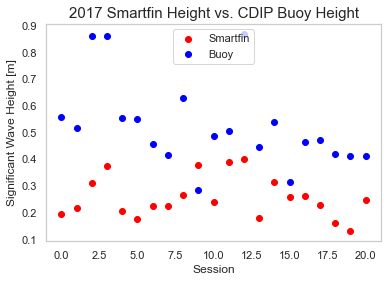

mean error is 51.09230658444817%
average difference is 0.27725806799555636 meters
average difference is 10.915677862791853 inches
length is 21


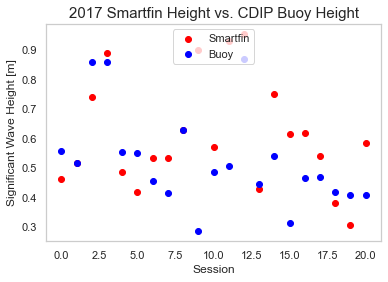

mean error is 21.509587245792016%
average difference is 0.1389492784638713 meters
average difference is 5.47044698805046 inches
length is 21


In [15]:
print(type(sig_heights))
fin = np.array(sig_heights)
print(type(fin))
buoy = np.array(CDIP_means)
fin3 = scalar*fin
data_to_plot = pd.DataFrame({'Smartfin': fin,'Buoy': buoy, 'fin_converted': fin3, 'diff1': abs(buoy-fin), 'diff2': abs(buoy-fin3)})
# data_to_plot.drop(data_to_plot[data_to_plot['diff1'] > 1].index, inplace = True)
# data_to_plot.drop(data_to_plot[data_to_plot['diff2'] > .3].index, inplace = True)
# data_to_plot.drop(data_to_plot[data_to_plot['Smartfin'] > 1].index, inplace = False)
# data_to_plot.drop(data_to_plot[data_to_plot['Buoy'] > 1.3].index, inplace = True)

x = list(range(0, len(data_to_plot)))

#Original data plot
plt.scatter(x, data_to_plot['Smartfin'], color='red')
plt.scatter(x, data_to_plot['Buoy'], color='blue')
plt.legend(['Smartfin', 'Buoy'], loc=9)
plt.xlabel('Session')
plt.ylabel('Significant Wave Height [m]')
plt.title('2017 Smartfin Height vs. CDIP Buoy Height', size=15)
plt.grid()
plt.show()

error = (abs(data_to_plot['Buoy'] - data_to_plot['Smartfin']) / data_to_plot['Buoy']) * 100
error = np.mean(error)
avgdiff1 = data_to_plot['diff1'].mean()
print('mean error is ' + str(error) + '%')
print('average difference is ' + str(avgdiff1) + ' meters')
print('average difference is ' + str(avgdiff1*39.3701) + ' inches')
print('length is ' + str(len(data_to_plot)))

#Converted data plot
plt.scatter(x, data_to_plot['fin_converted'], color='red')
plt.scatter(x, data_to_plot['Buoy'], color='blue')
plt.legend(['Smartfin', 'Buoy'], loc=9)
plt.xlabel('Session')
plt.ylabel('Significant Wave Height [m]')
plt.title('2017 Smartfin Height vs. CDIP Buoy Height', size=15)
plt.grid()
plt.show()

error3 = abs((1 - (data_to_plot['Buoy']/data_to_plot['fin_converted'])) *100)
error3 = np.mean(error3)
avgdiff2 = data_to_plot['diff2'].mean()
print('mean error is ' + str(error3) + '%')
print('average difference is ' + str(data_to_plot['diff2'].mean()) + ' meters')
print('average difference is ' + str(avgdiff2*39.3701) + ' inches')
print('length is ' + str(len(data_to_plot)))

In [16]:
scalar

2.377999999999999

Linear Regression Model

In [17]:
# (m,b) = np.polyfit(data_to_plot['Smartfin'],data_to_plot['Buoy'],1)
yp = np.polyval([m,b],data_to_plot['Smartfin'])
equation = 'y = ' + str(round(m,4)) + 'x' ' + ' + str(round(b,4))
plt.scatter(data_to_plot['Smartfin'],data_to_plot['Buoy'], color='red')
plt.plot(data_to_plot['Smartfin'],yp)
#plt.text(1,1, equation)

plt.xlabel('Smartfin Height [m]')
plt.ylabel('CDIP Buoy Height [m]')
plt.title('2017 Smartfin Height vs. CDIP Buoy Height', size=15)
plt.grid()
plt.show()
print('Prediction is: ' + str(equation))

#Calculate R^2 value
# x = fin
# y = buoy

correlation_matrix = np.corrcoef(data_to_plot['Smartfin'], data_to_plot['Buoy'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print('R^2 value is: ' + str(r_squared))
print(len(data_to_plot))

NameError: name 'm' is not defined

In [ ]:
# TODO: figure out how to implement the water time cropper and also match the height analysis in the smartfin app with the one here